In [23]:
import ast
from collections import defaultdict
import json
import math
import random
import time

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# from adjusttext import adjust_text

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

sns.set(style='ticks', font_scale=1.2)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [24]:
base_path = '/Volumes/Passport-1/data/shakespeare-and-co'

In [25]:
sc_books_path      = base_path + '/SCoData_books_v1.1_2021-01.csv'
sc_events_path     = base_path + '/SCoData_events_v1.1_2021-01.csv'
ucsd_books_path    = base_path + '/ucsd_books.csv'
scraped_books_path = base_path + '/books.processed.json'
matched_path       = base_path + '/goodreads-book-id-to-sc-uri.json'    

In [26]:
output_directory_path = '/Volumes/Passport-1/output/shakespeare-and-co'

<br><br><br><br>

# Functions

In [27]:
def convert_string_to_author(author):
    if not pd.isnull(author):   
        author = str(author)
        if ',' in author:
            author = author.split(',')[1].strip() + ' ' + author.split(',')[0].strip()
    return author

<br><br><br><br>

# Load S&C data

In [28]:
gr_to_sc_dict = json.load(open(matched_path, 'r'))
sc_to_gr_dict = {j: i for i, j in gr_to_sc_dict.items()}
len(gr_to_sc_dict), len(sc_to_gr_dict)

(4460, 4460)

In [29]:
sc_books_df = pd.read_csv(sc_books_path)
len(sc_books_df.index)

6018

In [30]:
sc_books_df.sample(3)

,uri,title,author,translator,editor,contributor,illustrator,introduction,preface,photographer,...,format,uncertain,ebook_url,volumes_issues,notes,event_count,borrow_count,purchase_count,circulation_years,updated
1155,https://shakespeareandco.princeton.edu/books/m...,La mort,"Maeterlinck, Maurice",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Book,False,https://archive.org/details/lamort00maetgoog,NaN,NaN,1,1,0,1956,2020-07-19T20:09:47+00:00
2716,https://shakespeareandco.princeton.edu/books/w...,The Not Impossible She,"Weigall, Arthur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Book,False,NaN,NaN,NaN,2,2,0,1926,2020-04-30T19:40:21+00:00
5872,https://shakespeareandco.princeton.edu/books/m...,The Morada,NaN,NaN,"Macleod, Norman",NaN,NaN,NaN,NaN,NaN,...,Periodical,False,NaN,"Vol. 2, no. 5, Winter 1931",NaN,1,0,0,1931,2020-06-08T15:05:14+00:00


In [31]:
sc_books_df['author'] = sc_books_df['author'].apply(convert_string_to_author)

In [32]:
book_sc_popularity_dict = {}
for i, r in sc_books_df.iterrows():
    if r['uri'] in sc_to_gr_dict:
        _book_id = sc_to_gr_dict[r['uri']]
        book_sc_popularity_dict[_book_id] = int(r['borrow_count'])
len(book_sc_popularity_dict)

4460

In [36]:
book_author_dict = {}
for i, r in sc_books_df.iterrows():
    if r['uri'] in sc_to_gr_dict:
        _book_id = sc_to_gr_dict[r['uri']]
        book_author_dict[_book_id] = convert_string_to_author(r['author'])
len(book_sc_popularity_dict)

4460

In [37]:
sc_events_df = pd.read_csv(sc_events_path)
len(sc_events_df.index)

35031

In [38]:
sc_events_df.sample(3)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image
9199,Subscription,1922-03-13,1922-04-13,https://shakespeareandco.princeton.edu/members...,Mr. Stern,"Stern, Mr.",12.0,14.0,1 month,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN
22430,Borrow,1935-05-23,1935-06-01,https://shakespeareandco.princeton.edu/members...,Fernand Colens,"Colens, Fernand",NaN,NaN,NaN,NaN,...,https://shakespeareandco.princeton.edu/books/r...,Jake,NaN,"Royde-Smith, Naomi Gwladys",1935.0,NaN,Lending Library Card,"Sylvia Beach, Fernand Colens Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/5b%2Fa...
25467,Renewal,1937-02-06,1937-03-06,https://shakespeareandco.princeton.edu/members...,Jean Lunn,"Lunn, Jean",NaN,30.0,1 month,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Address Book,"Sylvia Beach, Address Book 1935–1937, Box 70, ...",NaN,NaN


<br><br><br><br>

# Load the Goodreads books that appear in both Goodreads and S&C

In [47]:
matched_books_df = pd.read_json(scraped_books_path)
len(matched_books_df.index)

4454

In [48]:
matched_books_df.sample(3)

,bookID,isbn,yearFirstPublished,title,author,numPages,numRatings,numReviews,averageRating,ratingDistribution,lists,shelves,genres
3715,64683,1579124380,1919.0,Revolt in the Desert,T.E. Lawrence,416.0,407,28,3.89,"[118, 162, 96, 26, 5]",{},"{'to-read': 773, 'history': 51, 'currently-rea...","[History, Nonfiction, War > Military Fiction, ..."
138,108218,0684825864,1927.0,Men Without Women,Ernest Hemingway,153.0,10619,757,3.63,"[2043, 3999, 3441, 911, 225]",{'Collections of Short Stories': 0.07479734708...,"{'to-read': 15775, 'currently-reading': 801, '...","[Fiction, Classics, Short Stories, Literature,..."
3060,4566555,0836922182,NaN,The Other Side,Maxwell S. Burt,NaN,0,0,0.00,"[0, 0, 0, 0, 0]",{},{},[]


In [49]:
matched_books_df.columns

Index(['bookID', 'isbn', 'yearFirstPublished', 'title', 'author', 'numPages',
       'numRatings', 'numReviews', 'averageRating', 'ratingDistribution',
       'lists', 'shelves', 'genres'],
      dtype='object')

In [50]:
book_gr_popularity_dict = {}
for i, r in matched_books_df.iterrows():
    book_gr_popularity_dict[str(r['bookID'])] = r['numReviews']
len(book_gr_popularity_dict)

4454

In [51]:
book_title_dict = {}
for i, r in matched_books_df.iterrows():
    book_title_dict[str(r['bookID'])] = r['title']
len(book_gr_popularity_dict)

4454

In [52]:
book_year_dict = {}
for i, r in matched_books_df.iterrows():
    if not pd.isnull(r['yearFirstPublished']):
        _year = int(r['yearFirstPublished'])    
        if _year < 1940:
            book_year_dict[str(r['bookID'])] = _year
len(book_year_dict)

2614

In [53]:
book_shelves_dict = {}
for i, r in matched_books_df.iterrows():
    if not pd.isnull(r['shelves']):
        _shelf_dict = r['shelves']
        # _shelf_dict = _shelf_dict.replace("'", "\"")
        # _shelf_dict = json.loads(_shelf_dict)
        book_shelves_dict[str(r['bookID'])] = _shelf_dict
len(book_shelves_dict)

4454

In [54]:
book_lists_dict = {}
for i, r in matched_books_df.iterrows():
    if not pd.isnull(r['lists']):
        book_lists_dict[str(r['bookID'])] = r['lists']
len(book_lists_dict)

4454

In [55]:
# book_genres_dict = {}
# for i, r in matched_books_df.iterrows():
#     if not pd.isnull(r['genres']):
#         book_genres_dict[str(r['bookID'])] = r['genres']
# len(book_genres_dict)

In [56]:
author_books_dict = defaultdict(list)
for i, r in sc_books_df.iterrows():
    author_books_dict[r['author']].append(r['uri'])

In [57]:
len(matched_books_df.index)

4454

In [58]:
len(matched_books_df['author'].unique())

1726

In [59]:
len(matched_books_df[matched_books_df['numRatings'] > 0].index)

3940

In [60]:
len(matched_books_df[matched_books_df['numReviews'] > 0].index)

3223

<br><br><br><br>

# Compare book popularity

In [61]:
len(book_sc_popularity_dict), len(book_gr_popularity_dict)

(4460, 4454)

In [62]:
for _book_id, _popularity in sorted(book_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    if _book_id in book_title_dict:
        print(book_title_dict[_book_id], '////', convert_string_to_author(str(book_author_dict[_book_id])), '////', _popularity)
print('...\t ...')
for _book_id, _popularity in sorted(book_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    if _book_id in book_title_dict:
        print(book_title_dict[_book_id], '////', convert_string_to_author(str(book_author_dict[_book_id])), '////', _popularity)

A Portrait of the Artist as a Young Man //// James Joyce //// 56
Dubliners //// James Joyce //// 47
Pointed Roofs //// Dorothy M. Richardson //// 45
The Garden Party and Other Stories //// Katherine Mansfield //// 37
Mr Norris Changes Trains //// Christopher Isherwood //// 36
A Passage to India by E. M. Forster "The Annotated Classic Edition" //// E. M. Forster //// 35
Mrs. Dalloway //// Virginia Woolf //// 34
Women in Love by D.H. Lawrence //// D. H. Lawrence //// 33
Point Counter Point //// Aldous Huxley //// 33
The Good Earth //// Pearl S. Buck //// 33
...	 ...
Moderato cantabile //// Marguerite Duras //// 0
The Heart to Artemis: A Writer's Memoirs //// Bryher //// 0
A Child's History of England //// Charles Dickens //// 0
Nichomachean Ethics //// Aristotle //// 0
El Peque�o Larousse Ilustrado 2012 //// nan //// 0
Roget's International Thesaurus //// nan //// 0
The Cloud of Unknowing //// nan //// 0
The Logic Of Hegel: Translated From The Encyclopedia Of The Philosophical Sciences /

In [63]:
for _book_id, _popularity in sorted(book_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    if _book_id in book_title_dict:
        print(book_title_dict[_book_id], '////', convert_string_to_author(str(book_author_dict[_book_id])), '////', _popularity)
print('...\t ...')
for _book_id, _popularity in sorted(book_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    if _book_id in book_title_dict:
        print(book_title_dict[_book_id], '////', convert_string_to_author(str(book_author_dict[_book_id])), '////', _popularity)

Pride and Prejudice //// Jane Austen //// 77817
The Great Gatsby //// F. Scott Fitzgerald //// 75296
Jane Eyre //// Charlotte Brontë //// 47139
Wuthering Heights //// Emily Brontë //// 42403
Ten Little Niggers //// Agatha Christie //// 40393
Of Mice and Men //// John Steinbeck //// 37837
The Picture of Dorian Grey //// Oscar Wilde //// 37248
Little Women //// Louisa May Alcott //// 34878
Brave New World //// Aldous Huxley //// 34579
Dracula //// Bram Stoker //// 29583
...	 ...
Human Speech: Some Observations, Experiments, and Conclusions as to the Nature, Origin, Purpose and Possible Improvement of Human Speach //// Richard Paget //// 0
Keats and Shakespeare: A Study of Keat's Poetic Life from 1816 to 1820 //// John Middleton Murry //// 0
The Passionate Elopement //// Compton Mackenzie //// 0
COMING , SIR ! : The Autobiography of a Waiter //// Dave Marlowe //// 0
Jonathan Swift: Selections from the Journal to Stella, a Tale of a Tub, Persselections from the Journal to Stella, a Tale of

In [64]:
book_sc_rank_dict = {}
i = 0
previous_popularity = None
for _book_id, _popularity in sorted(book_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True):
    if _book_id in book_gr_popularity_dict:
        if _popularity != previous_popularity:
            i += 1
        book_sc_rank_dict[_book_id] = i
        previous_popularity = _popularity

book_sc_rank_dict = {_book: _rank/float(i) for _book, _rank in book_sc_rank_dict.items()}

book_gr_rank_dict = {}
i = 1
for _book_id, _popularity in sorted(book_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True):
    if _popularity != previous_popularity:
        i += 1
    book_gr_rank_dict[_book_id] = i
    previous_popularity = _popularity

book_gr_rank_dict = {_book: _rank/float(i) for _book, _rank in book_gr_rank_dict.items()}

len(book_sc_rank_dict), len(book_gr_rank_dict)

(4454, 4454)

In [73]:
dicts_to_plot = []
for _book_id, _rank_sc in book_sc_rank_dict.items():
    dicts_to_plot.append({'Book ID': _book_id,
                          'Title': book_title_dict[_book_id],
                          'Author': book_author_dict[_book_id],
                          'Goodreads Rank': book_gr_rank_dict[_book_id],
                          'SC Rank': _rank_sc,
                          'Goodreads Popularity': book_gr_popularity_dict[_book_id],
                          'SC Popularity': book_sc_popularity_dict[_book_id]})
df_to_plot = pd.DataFrame(dicts_to_plot)
len(df_to_plot.index)

4454

In [74]:
df_to_plot.sample(3)

,Book ID,Title,Author,Goodreads Rank,SC Rank,Goodreads Popularity,SC Popularity
4156,205476,Our Town,Thornton Wilder,0.267425,0.974359,1826,1
727,1305472,"Five Plays: The Gods Of The Mountain, The Gold...",Lord Dunsany,0.990043,0.846154,7,6
3985,3371869,Above the Dark Circus,Hugh Walpole,0.988620,0.974359,8,1


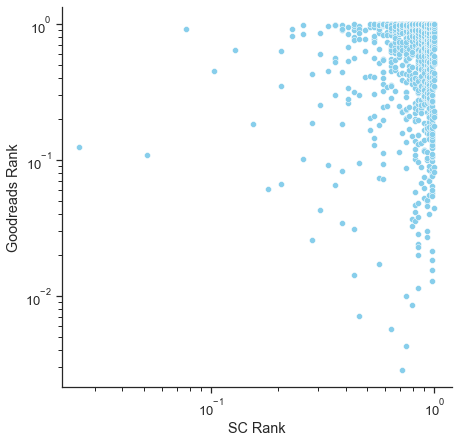

In [75]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_to_plot,
                     x='SC Rank',
                     y='Goodreads Rank',
                     color='skyblue')
ax.set(xscale='log', yscale='log')
sns.despine()
# plt.savefig(output_directory_path + '/scatter.sc_rank_x_gr_rank.books.png', bbox_inches='tight')

In [76]:
pearsonr(df_to_plot['SC Rank'], df_to_plot['Goodreads Rank'])

(0.27250551433940146, 1.112788860301071e-76)

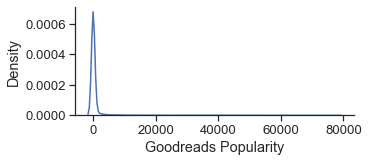

In [77]:
plt.figure(figsize=(5,2))
sns.kdeplot(df_to_plot['Goodreads Popularity'])
sns.despine()
plt.savefig(output_directory_path + '/kde.gr_books_popularity.png', bbox_inches='tight', dpi=300)

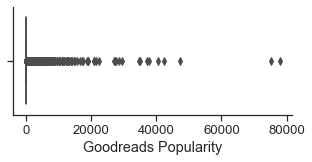

In [70]:
plt.figure(figsize=(5,2))
sns.boxplot(data=df_to_plot,
            x='Goodreads Popularity')
sns.despine()
plt.savefig(output_directory_path + '/box.gr_books_popularity.png', bbox_inches='tight', dpi=300)

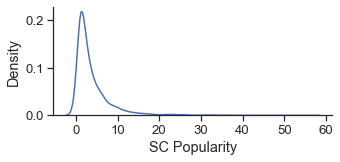

In [78]:
plt.figure(figsize=(5,2))
sns.kdeplot(df_to_plot['SC Popularity'])
sns.despine()
plt.savefig(output_directory_path + '/kde.sc_books_popularity.png', bbox_inches='tight', dpi=300)

In [79]:
max(df_to_plot['SC Popularity']), max(df_to_plot['Goodreads Popularity'])

(56, 77817)

<br><br><br><br>

# Explore connection between popularity and publication year

In [185]:
dicts_to_plot = []
for _book_id, _rank_sc in book_sc_rank_dict.items():
    if _book_id in book_year_dict:
        dicts_to_plot.append({'Book ID': _book_id,
                              'Title': book_title_dict[_book_id],
                              'Author': book_author_dict[_book_id],
                              'Goodreads Rank': book_gr_rank_dict[_book_id],
                              'S&C Rank': _rank_sc,
                              'Publication Year': book_year_dict[_book_id],
                              'Log(Publication Year)': math.log(book_year_dict[_book_id])})
df_to_plot = pd.DataFrame(dicts_to_plot)
len(df_to_plot.index)

2614

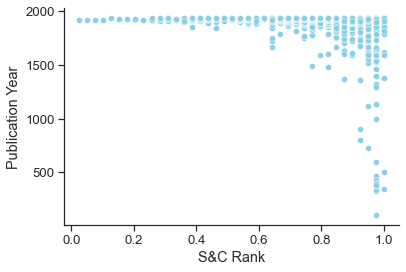

In [186]:
sns.scatterplot(data=df_to_plot,
                x='S&C Rank',
                y='Publication Year',
                color='skyblue')
sns.despine()
plt.savefig(output_directory_path + '/scatter.sc_rank_x_year.png', bbox_inches='tight')

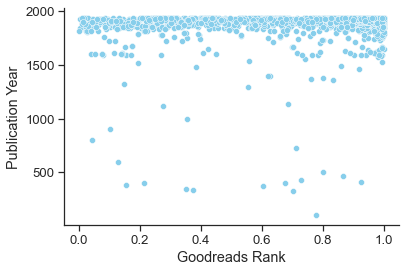

In [188]:
sns.scatterplot(data=df_to_plot,
                x='Goodreads Rank',
                y='Publication Year',
                color='skyblue')
sns.despine()
plt.savefig(output_directory_path + '/scatter.gr_rank_x_year.png', bbox_inches='tight')

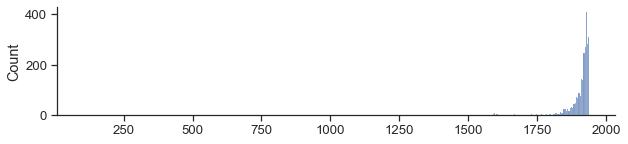

In [179]:
plt.figure(figsize=(10,2))
# sns.histplot([v for v in book_year_dict.values() if v < 1940 and v > 1800])
sns.histplot(list(book_year_dict.values()))
sns.despine()

<br><br><br><br>

# Explore change in rank

In [230]:
book_change_in_rank_dict = {}
for _book_id, _sc_rank in book_sc_rank_dict.items():
    _change_in_rank = _sc_rank - book_gr_rank_dict[_book_id]
    book_change_in_rank_dict[_book_id] = _change_in_rank

In [234]:
for _book_id, _change_in_rank in sorted(book_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[:11]:
    if _book_id in book_title_dict:
        _author = str(book_author_dict[_book_id])
        if ',' in _author:
            _author = _author.split(',')[1].strip() + ' ' + _author.split(',')[0].strip()
        print(round(_change_in_rank, 2), '////', book_title_dict[_book_id], '////', _author)
print('...\t ...')
for _book_id, _change_in_rank in sorted(book_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    if _book_id in book_title_dict:
        _author = str(book_author_dict[_book_id])
        if ',' in _author:
            _author = _author.split(',')[1].strip() + ' ' + _author.split(',')[0].strip()
        print(round(_change_in_rank, 2), '////', book_title_dict[_book_id], '////', _author)

0.96 //// Little Women //// Louisa May Alcott
0.96 //// Dracula //// Bram Stoker
0.96 //// The Wonderful Wizard of Oz //// L. Frank Baum
0.96 //// Lolita //// Vladimir Nabokov
0.95 //// Anna Karenina //// Leo Tolstoy
0.92 //// Macbeth //// William Shakespeare
0.92 //// The Trial //// Franz Kafka
0.92 //// Madame Bovary //// Gustave Flaubert
0.91 //// All Quiet on the Western Front //// Erich Maria Remarque
0.91 //// Uncle Tom's Cabin //// Harriet Beecher Stowe
0.91 //// Mansfield Park //// Jane Austen
...	 ...
-0.59 //// Bliss & Other Stories //// Katherine Mansfield
-0.6 //// The Tunnel: Pilgrimage, Volume 4 //// Dorothy M. Richardson
-0.63 //// Pointed Roofs, Backwater, Honeycomb //// Dorothy M. Richardson
-0.63 //// Pilgrimage: Backwater //// Dorothy M. Richardson
-0.63 //// The Fountain //// Charles Morgan
-0.63 //// Experiment in Autobiography: Discoveries & Conclusions of a Very Ordinary Brain (Since 1866) //// H. G. Wells
-0.64 //// Studies in the Psychology of Sex //// Havelock

In [236]:
author_change_in_rank_dict = {}
for _author, _sc_rank in author_sc_rank_dict.items():
    _change_in_rank = _sc_rank - author_gr_rank_dict[_author]
    author_change_in_rank_dict[_author] = _change_in_rank
len(author_change_in_rank_dict)

1650

In [238]:
for _author, _change_in_rank in sorted(author_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    _author = convert_string_to_author(_author)
    print(round(_change_in_rank, 2), '////', _author)
print('...\t ...')
for _author, _change_in_rank in sorted(author_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    _author = convert_string_to_author(_author)
    print(round(_change_in_rank, 2), '////', _author)

0.94 //// Bram Stoker
0.94 //// Louisa May Alcott
0.94 //// Vladimir Nabokov
0.91 //// Miguel de Cervantes
0.91 //// L. Frank Baum
0.88 //// Erich Maria Remarque
0.88 //// Homer
0.87 //// Gustave Flaubert
0.87 //// Harriet Beecher Stowe
0.86 //// Leo Tolstoy
...	 ...
-0.47 //// Havelock Ellis
-0.47 //// Kay Boyle
-0.49 //// Maurice Baring
-0.5 //// Margaret Kennedy
-0.51 //// Hugh Walpole
-0.57 //// Stephen Spender
-0.62 //// Charles Morgan
-0.62 //// George Moore
-0.7 //// Dorothy M. Richardson
-0.73 //// Compton Mackenzie


<br><br><br><br>

# Compare top 100 books

In [80]:
top_100_sc = [_book_id for _book_id, _popularity in sorted(book_sc_rank_dict.items(), key=lambda x: x[1], reverse=False)[:100]]
top_100_gr = [_book_id for _book_id, _popularity in sorted(book_gr_rank_dict.items(), key=lambda x: x[1], reverse=False)[:100]]

top_100_overlap = [_book_id for _book_id in top_100_gr if _book_id in top_100_sc]

len(top_100_overlap)

18

In [81]:
for _book_id in top_100_overlap:
    _author = str(book_author_dict[_book_id])
    if ',' in _author:
        _author = _author.split(',')[1].strip() + ' ' + _author.split(',')[0].strip()
    print(book_title_dict[_book_id] + ' by ' + _author)

Wuthering Heights by Emily Brontë
Brave New World by Aldous Huxley
Rebecca by Daphne Du Maurier
Gone with the Wind by Margaret Mitchell
The Grapes of Wrath by John Steinbeck
Moby-Dick or, the Whale by Herman Melville
The Sun Also Rises by Ernest Hemingway
Mrs. Dalloway by Virginia Woolf
A Farewell to Arms by Ernest Hemingway
The Good Earth by Pearl S. Buck
Tess of the D'Urbervilles by Thomas Hardy
To the Lighthouse by Virginia Woolf
As I Lay Dying by William Faulkner
The Sound and the Fury by William Faulkner
Ulysses by James Joyce
Dubliners by James Joyce
A Portrait of the Artist as a Young Man by James Joyce
Lady Chatterley's Lover: By D. H. Lawrence : Illustrated by D. H. Lawrence


In [85]:
dicts_to_plot = []
for _book_id in top_100_gr:
    if _book_id in book_year_dict:
        dicts_to_plot.append({'Book ID': _book_id,
                              'Title': book_title_dict[_book_id],
                              'Author': book_author_dict[_book_id],
                              'Goodreads Rank': book_gr_rank_dict[_book_id],
                              'SC Rank': _rank_sc,
                              'Top 100': 'Goodreads',
                              'Publication Year': book_year_dict[_book_id]})
for _book_id in top_100_sc:
    if _book_id in book_year_dict:
        dicts_to_plot.append({'Book ID': _book_id,
                              'Title': book_title_dict[_book_id],
                              'Author': book_author_dict[_book_id],
                              'Goodreads Rank': book_gr_rank_dict[_book_id],
                              'SC Rank': _rank_sc,
                              'Top 100': 'SC',
                              'Publication Year': book_year_dict[_book_id]})

df_to_plot = pd.DataFrame(dicts_to_plot)
len(df_to_plot.index)

192

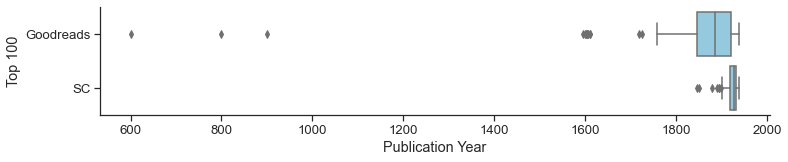

In [86]:
plt.figure(figsize=(12,2))
sns.boxplot(data=df_to_plot,
            y='Top 100',
            x='Publication Year',
            color='skyblue')
sns.despine()
plt.savefig(output_directory_path + '/box.top_100_x_year.png', bbox_inches='tight', dpi=300)

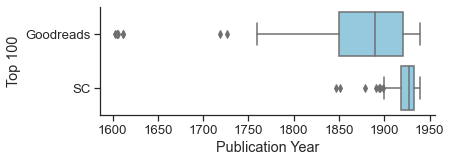

In [87]:
plt.figure(figsize=(6,2))
sns.boxplot(data=df_to_plot[df_to_plot['Publication Year'] > 1600],
            y='Top 100',
            x='Publication Year',
            color='skyblue')
sns.despine()
plt.savefig(output_directory_path + '/box.top_100_x_year.truncated.png', bbox_inches='tight', dpi=300)

In [294]:
for i, r in df_to_plot[df_to_plot['Top 100'] == 'S&C'].sort_values(by='Publication Year').iterrows():
    print(r['Publication Year'], r['Top 100'], r['Title'], r['Author'])

1847 S&C Wuthering Heights Brontë, Emily
1851 S&C Moby-Dick or, the Whale Melville, Herman
1879 S&C The Egoist Meredith, George
1891 S&C Tess of the D'Urbervilles Hardy, Thomas
1894 S&C Esther Waters Moore, George
1895 S&C Jude the Obscure Hardy, Thomas
1898 S&C The Plays of Bernard Shaw: Plays Pleasant and Unpleasant: Vol. 1. Unpleasant: Widowers' Houses, The Philanderer, Mrs Warren's Profession Shaw, George Bernard
1900 S&C Sister Carrie Dreiser, Theodore
1900 S&C Lord Jim Conrad, Joseph
1903 S&C The Way of All Flesh Butler, Samuel
1909 S&C Three Lives Stein, Gertrude
1910 S&C Studies in the Psychology of Sex Ellis, Havelock
1910 S&C Howards End Forster, E. M.
1912 S&C The Crock of Gold (Revised Edition) Stephens, James
1913 S&C Sons and Lovers Lawrence, D. H.
1914 S&C Exiles Joyce, James
1914 S&C Dubliners Joyce, James
1915 S&C Of Human Bondage Maugham, W. Somerset
1915 S&C Pointed Roofs Richardson, Dorothy M.
1916 S&C Pilgrimage: Backwater Richardson, Dorothy M.
1916 S&C Pointed Ro

In [295]:
for i, r in df_to_plot[df_to_plot['Top 100'] == 'Goodreads'].sort_values(by='Publication Year').iterrows():
    print(r['Publication Year'], r['Top 100'], r['Title'], r['Author'])

600 Goodreads The Sayings of Lao Tz Giles, Lionel
800 Goodreads The Odyssey Homer
900 Goodreads Beowulf nan
1595 Goodreads A Midsummer Night's Dream Shakespeare, William
1599 Goodreads Julius Caesar Shakespeare, William
1603 Goodreads Hamlet Shakespeare, William
1605 Goodreads King Lear Shakespeare, William
1605 Goodreads Don Quixote Cervantes, Miguel de
1605 Goodreads The History of Don Quixote de la Mancha (Great Books of the Western World, #29 - Cervantes) Cervantes, Miguel de
1606 Goodreads Macbeth Shakespeare, William
1611 Goodreads The Tempest Shakespeare, William
1611 Goodreads The Holy Bible: King James Version nan
1719 Goodreads Robinson Crusoe Defoe, Daniel
1726 Goodreads Gulliver's Travels: Travels into Several Remote Nations of the World. Swift, Jonathan
1759 Goodreads Candide Voltaire
1811 Goodreads Sense and Sensibility Austen, Jane
1813 Goodreads Pride and Prejudice Austen, Jane
1814 Goodreads Mansfield Park Austen, Jane
1815 Goodreads Emma Austen, Jane
1817 Goodreads Pe

<br><br><br><br>

# Compare most popular authors

In [221]:
author_sc_popularity_dict = defaultdict(int)
for _book_id, _popularity in book_sc_popularity_dict.items():
    if _book_id in book_title_dict:
        _author = book_author_dict[_book_id]
        author_sc_popularity_dict[str(_author).strip()] += _popularity

author_gr_popularity_dict = defaultdict(int)
for _book_id, _popularity in book_gr_popularity_dict.items():
    if _book_id in book_title_dict:
        _author = book_author_dict[_book_id]
        author_gr_popularity_dict[str(_author).strip()] += _popularity

len(author_sc_popularity_dict), len(author_gr_popularity_dict)

(1650, 1650)

In [228]:
for _author, _popularity in sorted(author_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    _author = convert_string_to_author(_author)
    print(_author, '////', _popularity)
print('...\t ...')
for _author, _popularity in sorted(author_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    _author = convert_string_to_author(_author)
    print(_author, '////', _popularity)

D. H. Lawrence //// 300
Virginia Woolf //// 249
Aldous Huxley //// 235
Dorothy M. Richardson //// 198
W. Somerset Maugham //// 187
James Joyce //// 182
Ernest Hemingway //// 182
John Galsworthy //// 180
Henry James //// 169
William Faulkner //// 163
...	 ...
Robin Fedden //// 0
Sheila Cousins //// 0
Xiaoxiao Sheng //// 0
Denis de Rougemont //// 0
Denys Kilham Roberts //// 0
Federico García Lorca //// 0
Jean Paris //// 0
Milovan Djilas //// 0
Marguerite Duras //// 0
Georg Wilhelm Friedrich Hegel //// 0


In [229]:
for _author, _popularity in sorted(author_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    _author = convert_string_to_author(_author)
    print(_author, '////', _popularity)
print('...\t ...')
for _author, _popularity in sorted(author_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    _author = convert_string_to_author(_author)
    print(_author, '////', _popularity)

Jane Austen //// 168543
Agatha Christie //// 125986
F. Scott Fitzgerald //// 84789
Charles Dickens //// 69609
John Steinbeck //// 60344
William Shakespeare //// 59935
Oscar Wilde //// 53992
Charlotte Brontë //// 53796
Fyodor Dostoyevsky //// 49215
Emily Brontë //// 42503
...	 ...
Gunnar Gunnarsson //// 0
E. V. Gatenby //// 0
S. P. B. Mais //// 0
Marcel Aymé //// 0
Pierre de Lanux //// 0
Bernard Berenson //// 0
Maud Cruttwell //// 0
Richard Paget //// 0
Dave Marlowe //// 0
Dante Gabriel Rossetti //// 0


In [239]:
author_sc_rank_dict = {}
i = 0
previous_popularity = None
for _author, _popularity in sorted(author_sc_popularity_dict.items(), key=lambda x: x[1], reverse=True):
    # if _book_id in book_gr_popularity_dict:
    if _popularity != previous_popularity:
        i += 1
    author_sc_rank_dict[_author] = i
    previous_popularity = _popularity

author_sc_rank_dict = {_author: _rank/float(i) for _author, _rank in author_sc_rank_dict.items()}

author_gr_rank_dict = {}
i = 1
for _author, _popularity in sorted(author_gr_popularity_dict.items(), key=lambda x: x[1], reverse=True):
    if _popularity != previous_popularity:
        i += 1
    author_gr_rank_dict[_author] = i
    previous_popularity = _popularity

author_gr_rank_dict = {_author: _rank/float(i) for _author, _rank in author_gr_rank_dict.items()}

len(author_sc_rank_dict), len(author_gr_rank_dict)

(1650, 1650)

In [246]:
dicts_to_plot = []
for _author, _rank_sc in author_sc_rank_dict.items():
    dicts_to_plot.append({'Author': convert_string_to_author(_author),
                          'Goodreads Rank': author_gr_rank_dict[_author],
                          'S&C Rank': _rank_sc})
df_to_plot = pd.DataFrame(dicts_to_plot)
len(df_to_plot.index)

1650

In [247]:
df_to_plot.sample(3)

,Author,Goodreads Rank,S&C Rank
1424,Albert Londres,0.995192,0.990385
1522,Frank Jellinek,0.997596,0.990385
983,A. S. M. Hutchinson,0.995192,0.980769


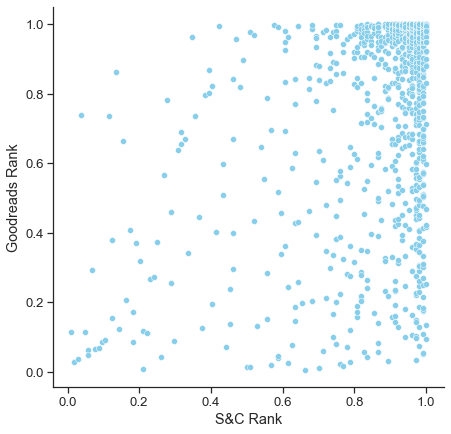

In [248]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_to_plot,
                x='S&C Rank',
                y='Goodreads Rank',
                color='skyblue')
sns.despine()

# for i, r in df_to_plot.iterrows():
#     _author = r['Author']
#     if ',' in _author:
#         _author = _author.split(',')[1] + ' ' + _author.split(',')[0]
#     if (r['S&C Rank'] < 0.4 and r['Goodreads Rank'] > 0.8) or (r['S&C Rank'] > 0.9 and r['Goodreads Rank'] < 0.1) :
#         plt.text(x=r['S&C Rank'], y=r['Goodreads Rank'], s=_author, fontdict=dict(color='black', alpha=0.5, size=12))


plt.savefig(output_directory_path + '/scatter.sc_rank_x_gr_rank.authors.png', bbox_inches='tight')

In [249]:
pearsonr(df_to_plot['S&C Rank'], df_to_plot['Goodreads Rank'])

(0.5108743488292075, 2.2435712663707293e-110)

<br><br><br><br>

# Examine shelves

In [263]:
shelf_count_dict = defaultdict(int)
for _book, _shelves in book_shelves_dict.items():
    for _shelf, _count in _shelves.items():
        if int(_count) >= 10:
            shelf_count_dict[_shelf] += 1

list_count_dict = defaultdict(int)
for _book, _lists in book_lists_dict.items():
    for _list, _count in _lists.items():
        if int(_count) >= 0:
            list_count_dict[_list] += 1

len(shelf_count_dict), len(list_count_dict)

(2035, 12623)

In [271]:
for _shelf, _count in sorted(shelf_count_dict.items(), key=lambda x: x[1], reverse=True)[:50]:
    print(_shelf, '////', _count)
# print('...')
# for _shelf, _count in sorted(shelf_count_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
#     print(_shelf, '////', _count)

to-read //// 2540
currently-reading //// 1585
fiction //// 1076
classics //// 1058
owned //// 823
own //// 816
favorites //// 737
classic //// 650
literature //// 623
books-i-own //// 613
kindle //// 566
wishlist //// 559
historical-fiction //// 486
library //// 478
default //// 471
2020 //// 459
novels //// 454
owned-books //// 436
ebook //// 435
to-buy //// 429
2018 //// 413
2021 //// 410
2019 //// 408
my-library //// 405
2017 //// 385
novel //// 372
2016 //// 362
british //// 352
audiobook //// 345
2015 //// 339
english //// 338
classic-literature //// 328
2014 //// 325
historical //// 318
non-fiction //// 309
audiobooks //// 307
my-books //// 306
ebooks //// 303
favourites //// 296
20th-century //// 292
history //// 287
2013 //// 281
british-literature //// 278
literary-fiction //// 276
1001-books //// 267
1001 //// 266
1001-books-to-read-before-you-die //// 256
19th-century //// 252
audio //// 251
school //// 250


In [279]:
shelf_sc_ranks_dict = defaultdict(list)
shelf_gr_ranks_dict = defaultdict(list)
for _book, _shelves in book_shelves_dict.items():
    for _shelf, _count in _shelves.items():
        if _count >= 5:
            shelf_sc_ranks_dict[_shelf].append(book_sc_rank_dict[_book])
            shelf_gr_ranks_dict[_shelf].append(book_gr_rank_dict[_book])

shelf_sc_rank_dict = {_shelf: np.mean(_ranks) for _shelf, _ranks in shelf_sc_ranks_dict.items() if len(_ranks) >= 10}
shelf_gr_rank_dict = {_shelf: np.mean(_ranks) for _shelf, _ranks in shelf_gr_ranks_dict.items() if len(_ranks) >= 10}

len(shelf_sc_rank_dict), len(shelf_gr_rank_dict)

(666, 666)

In [280]:
shelf_change_in_rank_dict = {_shelf: _sc_rank - shelf_gr_rank_dict[_shelf] for _shelf, _sc_rank in shelf_sc_rank_dict.items()}

len(shelf_change_in_rank_dict)

666

In [284]:
for _shelf, _change_in_rank in sorted(shelf_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(round(_change_in_rank, 2), '////', _shelf)
print('...')
for _shelf, _change_in_rank in sorted(shelf_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    print(round(_change_in_rank, 2), '////', _shelf)

0.75 //// read-in-school
0.73 //// school-reading
0.72 //// william-shakespeare
0.71 //// thriller-mystery
0.71 //// chick-lit
0.7 //// classics-read
0.69 //// the-classics
0.69 //// realistic-fiction
0.69 //// childrens-lit
0.68 //// great-american-read
...
0.06 //// to-read
0.04 //// bloomsbury
0.03 //// stream-of-consciousness
0.01 //// virago-modern-classics
-0.03 //// lit-crit
-0.03 //// literary-criticism
-0.03 //// virago
-0.05 //// d-h-lawrence
-0.05 //// criticism
-0.08 //// joyce


<br><br><br><br>

# Examine lists

In [265]:
for _list, _count in sorted(list_count_dict.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(_list, '////', _count)
print('...')
for _list, _count in sorted(list_count_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    print(_list, '////', _count)

Best Books Ever //// 465
Books That Everyone Should Read At Least Once //// 312
100 Books to Read in a Lifetime: Readers' Picks //// 239
Best Books of the 20th Century //// 217
1001 Books You Must Read Before You Die //// 212
Must Read Classics //// 188
The Great Classics You Have Not Read Yet //// 170
The Guardian's "1000 Novels Everyone Must Read" //// 168
Best Books of the 19th Century //// 164
Books that Blew Me Away and that I Still Think About (of all types) //// 162
I Should Probably Read This Sometime... //// 155
Read Them Twice...At Least //// 153
Favorite Books //// 151
Books that Exceeded your Expectations //// 144
Books With Unforgettable Characters //// 143
The Most Begun "Read but Unfinished" (Started) book ever //// 142
I'm glad someone made me read this book //// 139
What To Read Next //// 135
Best for Book Clubs //// 134
Books you have read more than one time //// 134
Stories For Book Lovers //// 131
Best Book Titles //// 131
Best Books of the Decade: 1930s //// 127
Bo

In [287]:
list_sc_ranks_dict = defaultdict(list)
list_gr_ranks_dict = defaultdict(list)
for _book, _shelves in book_lists_dict.items():
    for _shelf, _count in _shelves.items():
        if _count >= 0:
            list_sc_ranks_dict[_shelf].append(book_sc_rank_dict[_book])
            list_gr_ranks_dict[_shelf].append(book_gr_rank_dict[_book])

list_sc_rank_dict = {_shelf: np.mean(_ranks) for _shelf, _ranks in list_sc_ranks_dict.items() if len(_ranks) >= 10}
list_gr_rank_dict = {_shelf: np.mean(_ranks) for _shelf, _ranks in list_gr_ranks_dict.items() if len(_ranks) >= 10}

len(list_sc_rank_dict), len(list_gr_rank_dict)

(1422, 1422)

In [289]:
list_change_in_rank_dict = {_shelf: _sc_rank - list_gr_rank_dict[_shelf] for _shelf, _sc_rank in list_sc_rank_dict.items()}

len(list_change_in_rank_dict)

1422

In [290]:
for _shelf, _change_in_rank in sorted(list_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(round(_change_in_rank, 2), '////', _shelf)
print('...')
for _shelf, _change_in_rank in sorted(list_change_in_rank_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
    print(round(_change_in_rank, 2), '////', _shelf)

0.84 //// 100 Must Read Books
0.84 //// Clean/Secular/Non Religious Reads
0.83 //// Books that reached 1000 editions (or more)
0.83 //// Half a million ratings to a million ratings
0.82 //// Amazing books that won't make you blush, squirm, get sick or have nightmares!
0.81 //// Proliferation of Classics
0.81 //// Books Every Child Should Read
0.81 //// ONE DAY Best Summer Reads
0.8 //// Best Free eBooks
0.8 //// My Favorite Childhood books
...
-0.05 //// Interwar British Vogue Recommends...
-0.05 //// Best of Sinclair Lewis
-0.05 //// James Joyce Reading List
-0.06 //// REALLY Seriously Underrated Books (100 to 500 Ratings)
-0.07 //// Best of George Bernard Shaw
-0.07 //// Modernism - An Alternate Canon
-0.08 //// Books banned in Ireland 1928-1929
-0.08 //// REALLY Underrated Books (Fewer than 1,000 Ratings)
-0.08 //// Best of D.H. Lawrence
-0.12 //// Underrated Bestsellers, Fewer Than 100 Ratings


# TODO: predict change in rank using shelves
